# Lunar Lander using DQN

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import itertools
import random

import DQNconfig

## Environment 

In [3]:
env = gym.make("LunarLander-v2")
obs = env.reset()
episode_reward = 0.0

## Replay memory

In [4]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)
    
    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.int64)).unsqueeze(1)
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, done, info = env.step(action)
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [5]:
replay_memory = Replay_memory(env, DQNconfig.BUFFER_SIZE, DQNconfig.MIN_REPLAY_SIZE, DQNconfig.BATCH_SIZE).initialize()

## DQN

In [6]:
class DQN(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.a1 = torch.nn.Linear(inputs, 64)
        self.a2 = torch.nn.Linear(64, outputs)
    
    def forward(self, x):
        output = self.a1(x)
        output = torch.tanh(output)
        return self.a2(output)
    
    def __call__(self, x):
        return self.forward(x)

dqn_policy = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target = DQN(env.observation_space.shape[0], env.action_space.n)
dqn_target.load_state_dict(dqn_policy.state_dict())
dqn_target.eval()
loss_fn = torch.nn.SmoothL1Loss()
learning_rate = 0.001
optimizer = torch.optim.Adam(dqn_policy.parameters(), lr=learning_rate)

In [7]:
def epsilon_greedy_policy(epsilon, obs):
    rnd_sample = random.random()
    if rnd_sample <= epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            action = int(torch.argmax(dqn_policy(torch.Tensor(obs))))
    return action

## Training

In [22]:
obs = env.reset()
eps_threshold = DQNconfig.EPS_START
episode = 1

rewards = []
episodes = []

In [23]:
for step in itertools.count():
    action = epsilon_greedy_policy(eps_threshold, obs)
    new_obs, reward, done, _ = env.step(action)
    replay_memory.append(Transition(obs, action, reward, done, new_obs))
    episode_reward += reward
    obs = new_obs
    
    if done:
        episode += 1
        eps_threshold = np.max((eps_threshold * DQNconfig.EPS_DECAY, DQNconfig.EPS_END))
        replay_memory.rewards.append(episode_reward)
        obs = env.reset()
        avg_res = np.mean(replay_memory.rewards)

        if episode % 50 == 0: 
            avg_res = np.mean(replay_memory.rewards)
            rewards.append(avg_res)
            episodes.append(episode)
            print(f'Episode: {episode} Avg Results: {avg_res} Epsilon: {eps_threshold}')

        if avg_res >= 195:
            rewards.append(avg_res)
            episodes.append(episode)
            print(f'Solved at episode: {episode} Avg Results: {avg_res}')
            break
        
        if step % DQNconfig.TARGET_UPDATE_FREQ == 0:
            dqn_target.load_state_dict(dqn_policy.state_dict())

        episode_reward = 0

    b_states, b_actions, b_rewards, b_dones, b_next_states = replay_memory.sample_batch()

    qvalues = dqn_policy(b_states).gather(1, b_actions)
    
    with torch.no_grad():
        target_qvalues = dqn_target(b_next_states)
        max_target_qvalues = torch.max(target_qvalues, axis=1).values.unsqueeze(1)
        expected_qvalues = b_rewards + DQNconfig.GAMMA * (1 - b_dones.type(torch.int64)) * max_target_qvalues

    loss = loss_fn(qvalues, expected_qvalues)
    optimizer.zero_grad()
    loss.backward()
    for param in dqn_policy.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Episode: 50 Avg Results: -112.62318891109388 Epsilon: 0.7822236754458713
Episode: 100 Avg Results: -61.174236879147166 Epsilon: 0.6088145090359074
Episode: 150 Avg Results: -29.78895911396043 Epsilon: 0.4738479773082268
Episode: 200 Avg Results: -9.258560428256331 Epsilon: 0.36880183088056995
Episode: 250 Avg Results: 22.76930116917114 Epsilon: 0.28704309604425327
Episode: 300 Avg Results: 105.44510166586142 Epsilon: 0.22340924607110255
Episode: 350 Avg Results: 151.54067388692403 Epsilon: 0.17388222158237718
Episode: 400 Avg Results: 189.8331327226724 Epsilon: 0.1353347165085562
Episode: 450 Avg Results: 154.35457882360316 Epsilon: 0.10533270926593409
Solved at episode: 489 Avg Results: 195.91438298237452


## Evaluation

#### Rewards Graph

<function matplotlib.pyplot.show(close=None, block=None)>

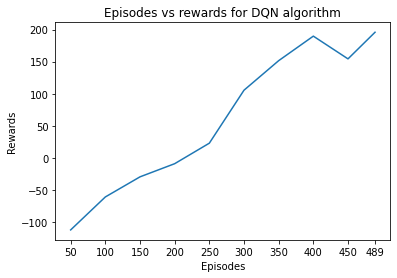

In [28]:
plt.plot(episodes, rewards)
plt.title('Episodes vs rewards for DQN algorithm')
plt.xlabel('Episodes')
plt.xticks(np.append(np.arange(min(episodes), max(episodes)+1, 50), episodes[-1]))
plt.ylabel('Rewards')
plt.show